In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import segpath2path, pairwise_distances, point2segments

In [2]:
import matplotlib.transforms as mtransforms

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 7.5
plt.rcParams['axes.titlesize'] = 7.5

figw2 = 3.307
figw1 = 6.85


def complete_figure(fig, axes, index):    
    trans = mtransforms.ScaledTranslation(0.02, -0.02, fig.dpi_scale_trans)
    for label, ax in zip(index, axes.flatten()):
        ax.text(0.0, 1.0, '({})'.format(label), transform=ax.transAxes + trans,
                verticalalignment='top', fontfamily='Arial')

In [3]:
record_dir = 'straight_route_following' 
var_name = 'noise_motor'
ls_value = -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9
n_condition = len(ls_value)
catchment_radius = 0.372 / 2 ## 0.372 is the wheel axle length of Freight

In [4]:
n_trial = 100
n_epoch_train, n_epoch_test = 180, 250
goal_idx = -1
ls_model_keys = 'visual-localisor', 'pure-pursuit', 'lamb'
ls_model_name = 'visual-localisor', 'pure-pursuit', 'differential-MB'
ls_color = 'tab:orange', 'tab:green', 'tab:red'

In [5]:
data_path = np.load(os.path.join('records', record_dir, 'data_path.npy'), allow_pickle=True)[()]

In [6]:
data_dist_test2goal, data_min_dist2goal, data_time_min_dist2goal = {}, {}, {}
data_dist_testtrunc2goal = {}
data_time_catchment = {}

for model_name in ls_model_name:
    data_path[model_name]['test'] = (data_path[model_name]['test'].T - data_path[model_name]['test'][:, :, :, 0].T).T
    path_train_init = data_path[model_name]['train'][:, :, :, 0]
    data_path[model_name]['train'] = (data_path[model_name]['train'].T - path_train_init.T).T
    path_train_goal = data_path[model_name]['train'][:, :, :, -1]
    dist_init2goal = np.linalg.norm(path_train_goal, axis=-1)
    dist_test2goal = np.linalg.norm(path_train_goal[:, :, :, np.newaxis] - data_path[model_name]['test'], axis=2)
    time_min_dist2goal = np.nanargmin(dist_test2goal, axis=2)
    min_dist2goal = np.nanmin(dist_test2goal, axis=2)
    
    data_dist_test2goal[model_name] = dist_test2goal
    data_min_dist2goal[model_name] = min_dist2goal
    data_time_min_dist2goal[model_name] = time_min_dist2goal
    
    nan_mask = (time_min_dist2goal.T < np.tile(np.arange(n_epoch_test), (n_condition, n_trial, 1)).T).T
    nan_mask_path = np.moveaxis(np.tile(nan_mask, (2, 1, 1, 1)), 0, 2)
    data_dist_testtrunc2goal[model_name] = np.where(nan_mask, np.nan, dist_test2goal)
    data_path[model_name]['test_trunc'] = np.where(nan_mask_path, np.nan, data_path[model_name]['test'])

    time_catchment = np.argmax(dist_test2goal <= catchment_radius, axis=-1)
    data_time_catchment[model_name] = np.where(time_catchment == 0, np.nan, time_catchment)
    
    ### base
    data_path[model_name]['base'] = (data_path[model_name]['base'].T - data_path[model_name]['base'][:, :, :, 0].T).T
    dist_base2goal = np.linalg.norm(path_train_goal[:, :, :, np.newaxis] - data_path[model_name]['base'], axis=2)
    time_min_dist2goal = np.argmin(dist_base2goal, axis=2)
    nan_mask = (time_min_dist2goal.T < np.tile(np.arange(n_epoch_test), (n_condition, n_trial, 1)).T).T
    nan_mask_path = np.moveaxis(np.tile(nan_mask, (2, 1, 1, 1)), 0, 2)
    data_path[model_name]['base_trunc'] = np.where(nan_mask_path, np.nan, data_path[model_name]['base'])

In [7]:
data_dsim_test2train, data_dist_test2path = {}, {}

for model_name in ls_model_name:
    model_dsim_test2train, model_dist_test2path = [], []
    for path_train_val, path_test_val, time_mindist_test2goal_val in zip(data_path[model_name]['train'], 
                                                                          data_path[model_name]['test_trunc'],
                                                                          data_time_min_dist2goal[model_name]):
        val_time_mindist = []
        val_dist_test2path = np.full((n_trial, n_epoch_test), np.nan)
        for trial_idx, (path_train_trial, path_test_trial, time_mindist) in enumerate(zip(path_train_val, 
                                                                                        path_test_val, 
                                                                                        time_mindist_test2goal_val)):
            dsim_test2train, dist_test2path = segpath2path(path_test_trial.T[:time_mindist + 1], path_train_trial.T)
            val_time_mindist.append(dsim_test2train)
            val_dist_test2path[trial_idx, :time_mindist + 1] = dist_test2path
        model_dsim_test2train.append(val_time_mindist)
        model_dist_test2path.append(val_dist_test2path)
        
    data_dsim_test2train[model_name] = np.array(model_dsim_test2train)
    data_dist_test2path[model_name] = np.array(model_dist_test2path)

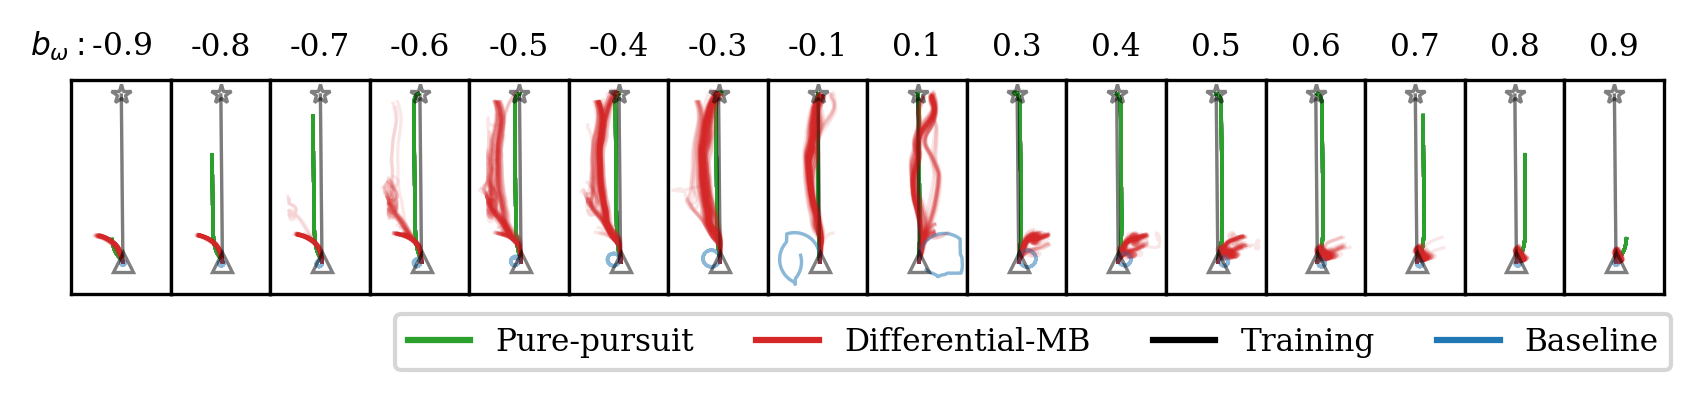

In [14]:
fig, axes = plt.subplot_mosaic('''
                                ABCDEFGIigfedcba
                                ''', sharex=True, sharey=True, figsize=(figw1, 3.5), dpi=300)
fig.subplots_adjust(hspace=0, wspace=0)

lw = 0.8
ls_model_name = 'pure-pursuit', 'differential-MB'
ls_color = 'tab:green', 'tab:red'

for model_name, color in zip(ls_model_name, ls_color):
    for dtp_base, dtp_train, dtp_testtrunc, val, ak in zip(data_path[model_name]['base'],
                                                           data_path[model_name]['train'], 
                                                           data_path[model_name]['test_trunc'],
                                                           ls_value, 'ABCDEFGHIJihgfedcba'):
        
        if ak not in 'JHh':
            ax = axes[ak]
            for trial_idx, (path_base, path_train, path_test_trunc) in enumerate(zip(dtp_base, dtp_train, dtp_testtrunc)):
                if trial_idx % 1 == 0:
                    ax.plot(path_test_trunc[1], -path_test_trunc[0], c=color, alpha=0.1, lw=lw)#, ls='dotted')

            ax.plot(path_train[1, :goal_idx], -path_train[0, :goal_idx], c='k', alpha=0.3, lw=lw)
            ax.plot(path_base[1, :180], -path_base[0, :180], c='tab:blue', alpha=0.3, lw=lw)
            
            if model_name == 'differential-MB':
                ax.plot(path_train[:, goal_idx][1], -path_train[:, goal_idx][0], c='k', alpha=0.5, 
                        marker='*', markersize=5, mfc='none', markeredgewidth=lw)
                ax.plot(path_train[:, 0][1], -path_train[:, 0][0], c='k', alpha=0.5,
                        marker='^', markersize=5, mfc='none', markeredgewidth=lw)
    


for ak, val in zip('ABCDEFGHIJihgfedcba', ls_value):
    if ak not in 'JHh':
        ax = axes[ak]
        ax.set_aspect('equal')    
        if ak == 'A': 
            ax.set_title('$b_\omega:${}'.format(val), x=0.2)
        else:
            ax.set_title(val)
                
        ax.set_xticks([])
        ax.set_yticks([])
#         ax.xaxis.set_tick_params(labelsize=6)
#         ax.yaxis.set_tick_params(labelsize=6)

for model_name, color in zip(['Pure-pursuit', 'Differential-MB'], ls_color):
    axes['A'].plot([], [], c=color, label=model_name)
axes['A'].plot([], [], c='k', label='Training')
axes['A'].plot([], [], c='tab:blue', label='Baseline')
axes['A'].legend(ncol=5, loc='upper left', bbox_to_anchor=(3.1, -0.02))

[]

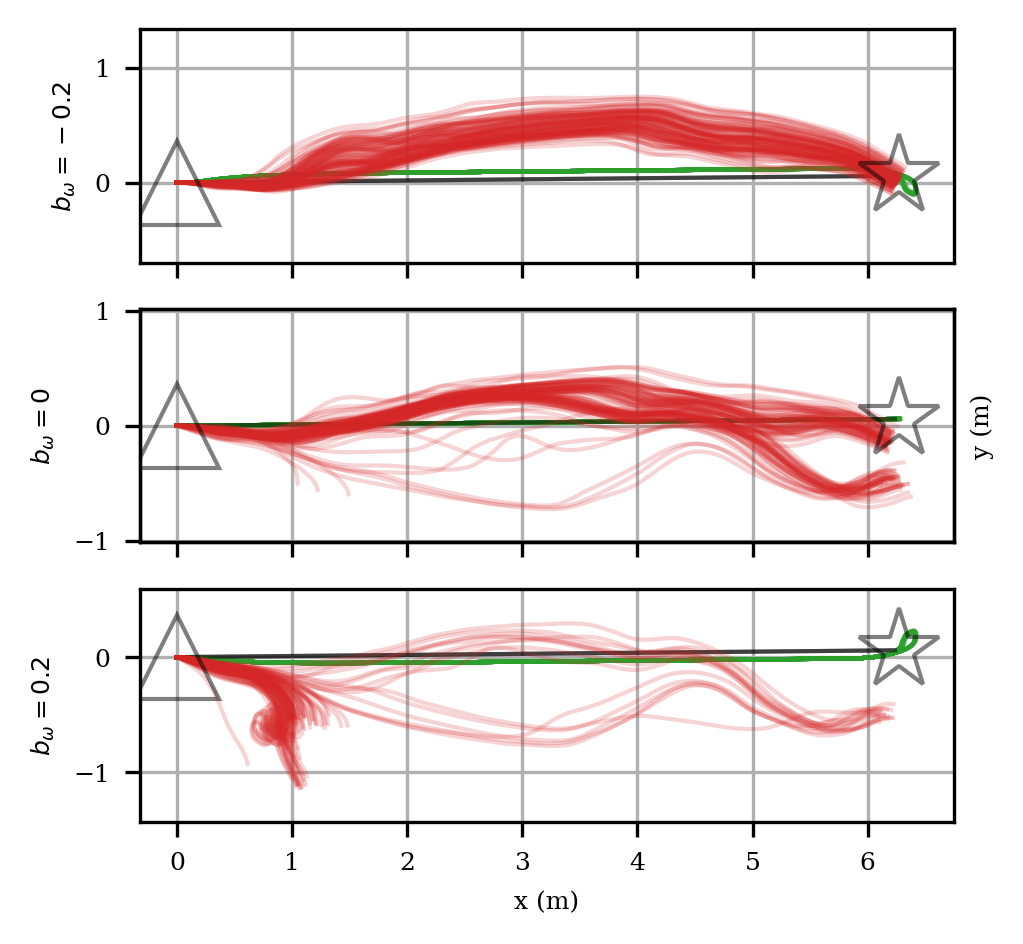

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(3.5, 3.5), sharex=True, dpi=300)

lw = 1

ls_validx = 7, 9, 11


for validx, ax in zip(ls_validx, axes):
    for model_name, color in zip(ls_model_name, ls_color):
        dtp_base, dtp_train, dtp_test, dtp_test_trunc = [data_path[model_name][phase][validx] for phase in ('base', 'train', 'test', 'test_trunc')]
        for trial_idx, (path_base, path_train, path_test, path_test_trunc) in enumerate(zip(dtp_base, dtp_train, dtp_test, dtp_test_trunc)):
            ax.plot(-path_test_trunc[0], -path_test_trunc[1], c=color, alpha=0.2, lw=lw)#, ls=ls)
            
            if trial_idx == 0:
                ax.plot(-path_train[:, :goal_idx][0], -path_train[:, :goal_idx][1], c='k', alpha=0.5, lw=lw)
                ax.plot(-path_base[1, :180][0], -path_base[1, :180][1], c='tab:blue', alpha=0.5, lw=lw)

    ax.plot(-path_train[:, goal_idx][0], -path_train[:, goal_idx][1], c='k', alpha=0.5, 
            marker='*', markersize=20, mfc='none', markeredgewidth=lw)
    ax.plot(-path_train[:, 0][0], -path_train[:, 0][1], c='k', alpha=0.5,
            marker='^', markersize=20, mfc='none', markeredgewidth=lw)
    
    ax.set_ylabel('$b_\omega={}$'.format(ls_value[validx]), fontsize=6)
    ax.set_aspect('equal', adjustable='datalim', share=True)    
    ax.grid()
    ax.xaxis.set_tick_params(labelsize=6)
    ax.yaxis.set_tick_params(labelsize=6)
#     ax.yaxis.tick_right()
#     ax.yaxis.set_label_position("right")    

for model_name, color in zip(ls_model_name, ls_color):
    ax.plot([], [], c=color, label=model_name)

ax.plot([], [], c='k', label='training')
ax.plot([], [], c='tab:blue', label='baseline')

axes[-1].set_xlabel('x (m)', fontsize=6)
# fig.legend(fontsize=6, ncol=2, loc=6)
axes[1].set_ylim(-1.2, 1.2)
axes[1].set_yticks([-1, 0, 1])
ax2 = axes[1].twinx()
ax2.set_ylabel('y (m)', fontsize=6)
ax2.set_yticks([], [])

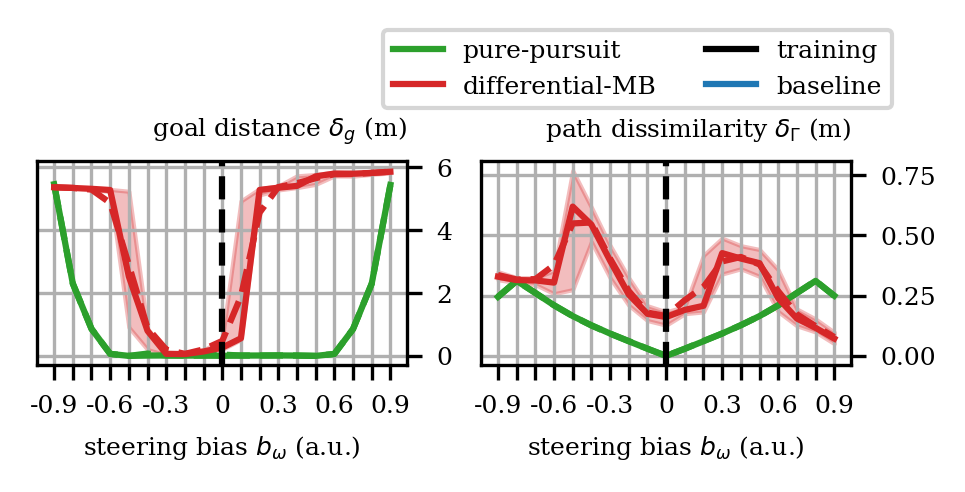

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(3.5, 0.9), dpi=300)

for model_name, color in zip(ls_model_name, ls_color):
    for ax, data in zip(axes, (data_min_dist2goal[model_name], data_dsim_test2train[model_name])):
        quant = np.nanquantile(data, (0.25, 0.5, 0.75), axis=1)
        avg = np.nanmean(data, axis=1)
        ax.plot(np.arange(n_condition), avg, color=color, ls='dashed')
        ax.plot(np.arange(n_condition), quant[1], color=color, label=model_name)
        ax.fill_between(np.arange(n_condition), quant[0], quant[2], color=color, alpha=0.3)

    
for ax, yl in zip(axes, ('goal distance $\delta_g$ (m)', 'path dissimilarity $\delta_\Gamma$ (m)')):
    ax.axvline(9, color='k', ls='dashed')
    ax.set_title(yl, fontsize=6, loc='right')
    ax.set_xticks(np.arange(n_condition), [])
    ax.xaxis.set_tick_params(labelsize=6)
    ax.yaxis.set_tick_params(labelsize=6)
    ax.yaxis.tick_right()
    ax.set_xlabel('steering bias $b_\omega$ (a.u.)', fontsize=6)
    
    ax.set_xticklabels([-0.9, '', '', -0.6, '', '', -0.3, '', '', 0, '', '', 0.3, '', '', 0.6, '', '', 0.9])
    ax.grid()


    
axes[1].plot([], [], c='k', label='training')
axes[1].plot([], [], c='tab:blue', label='baseline')
axes[1].legend(fontsize=6, ncol=2, loc='lower left', bbox_to_anchor=(-0.3, 1.2))

/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


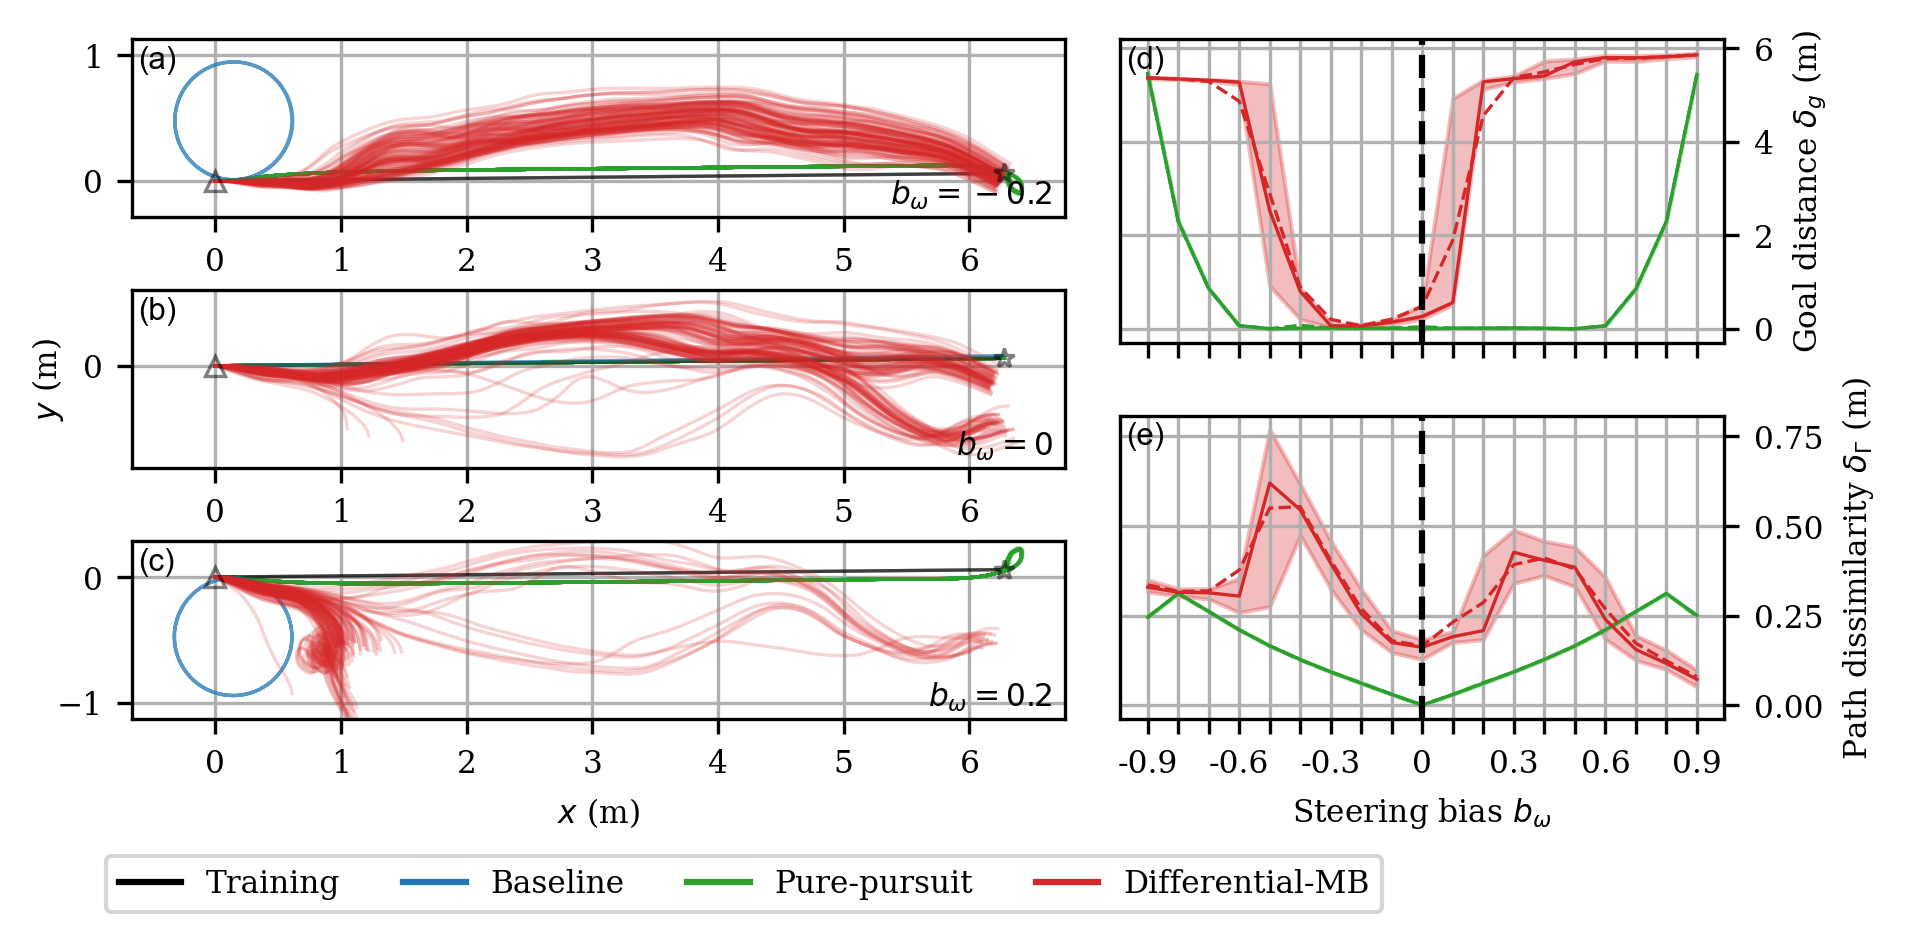

In [124]:

ls_model_name = 'pure-pursuit', 'differential-MB'
ls_color = 'tab:green', 'tab:red'


fig, axes = plt.subplot_mosaic('''
                                AAADD
                                AAADD
                                AAADD
                                ...DD
                                BBBDD
                                BBB..
                                BBBEE
                                ...EE
                                CCCEE
                                CCCEE
                                CCCEE
                                ''', figsize=(figw1, 3), dpi=300, layout='tight')

# fig.subplots_adjust(hspace=2, wspace=0.5)

lw = 0.8

ls_validx = 7, 9, 11


for validx, ak, ym in zip(ls_validx, 'ABC', ('', '$y$ (m)', '')):
    ax = axes[ak]
    for model_name, color in zip(ls_model_name, ls_color):
        dtp_base, dtp_train, dtp_test, dtp_test_trunc = [data_path[model_name][phase][validx] for phase in ('base', 'train', 'test', 'test_trunc')]
        for trial_idx, (path_base, path_train, path_test, path_test_trunc) in enumerate(zip(dtp_base, dtp_train, dtp_test, dtp_test_trunc)):
            ax.plot(-path_test_trunc[0], -path_test_trunc[1], c=color, alpha=0.2, lw=lw)#, ls=ls)
            
            if trial_idx == 0:
                ax.plot(-path_train[:, :goal_idx][0], -path_train[:, :goal_idx][1], c='k', alpha=0.5, lw=lw)
                ax.plot(-path_base[0, :180], -path_base[1, :180], c='tab:blue', alpha=0.5, lw=lw)

    ax.plot(-path_train[:, goal_idx][0], -path_train[:, goal_idx][1], c='k', alpha=0.5, 
            marker='*', markersize=5, mfc='none', markeredgewidth=lw)
    ax.plot(-path_train[:, 0][0], -path_train[:, 0][1], c='k', alpha=0.5,
            marker='^', markersize=5, mfc='none', markeredgewidth=lw)
    
    ax.set_title('$b_\omega={}$  '.format(ls_value[validx]), loc='right', y=0.05, pad=1)
    ax.set_ylabel(ym)
    ax.set_aspect('equal', adjustable='datalim')    
    ax.sharex(axes['A'])
#     ax.sharey(axes['A'])

axes['B'].set_yticks([0])
    
for model_name, color in zip(ls_model_name, ls_color):
    for ak, data in zip('DE', (data_min_dist2goal[model_name], data_dsim_test2train[model_name])):
        ax = axes[ak]
        quant = np.nanquantile(data, (0.25, 0.5, 0.75), axis=1)
        avg = np.nanmean(data, axis=1)
        ax.plot(np.arange(n_condition), avg, color=color, ls='dashed', lw=lw)
        ax.plot(np.arange(n_condition), quant[1], color=color, lw=lw)
        ax.fill_between(np.arange(n_condition), quant[0], quant[2], color=color, alpha=0.3)

    
for ak, yl in zip('DE', ('Goal distance $\delta_g$ (m)', 'Path dissimilarity $\delta_\Gamma$ (m)')):
    ax = axes[ak]
    ax.axvline(9, color='k', ls='dashed')
    ax.set_ylabel(yl)
    ax.set_xticks(np.arange(n_condition), [])
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')

    
    ax.set_xticklabels([-0.9, '', '', -0.6, '', '', -0.3, '', '', 0, '', '', 0.3, '', '', 0.6, '', '', 0.9])


    
    
for ax in axes.values():
    ax.grid()

for ak in 'D':
    axes[ak].set_xticklabels([])

axes['C'].set_xlabel('$x$ (m)')
axes['E'].set_xlabel('Steering bias $b_\omega$')

axes['C'].plot([], [], c='k', label='Training')
axes['C'].plot([], [], c='tab:blue', label='Baseline')
for model_name, color in zip(['Pure-pursuit', 'Differential-MB'], ls_color):
    axes['C'].plot([], [], c=color, label=model_name)

plt.figlegend(ncol=4, loc='upper left', bbox_to_anchor=(0.105, -0.01))

ax = np.array(list(axes.values()))
complete_figure(fig, ax, 'adbec')